In [1]:
import ipaddress
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime, timedelta
import numpy as np
from pathlib import Path
from collections import Counter
import ast
import matplotlib.colors as mcolors
import maxminddb
from itertools import combinations

In [2]:
def ip_to_subnet(ip):
   try:
       return str(ipaddress.IPv4Network(f"{ip}/24", strict=False).network_address) + "/24"
   except:
       return None

def ip_to_asn(ip_address, db_path='data/external/GeoLite2-ASN.mmdb'):
    try:
        with maxminddb.open_database(db_path) as reader:
            result = reader.get(ip_address)
            return result['autonomous_system_organization']
    except Exception as e:
        return None
   
def set_plt_latex_format():
    plt.rcParams.update({
        "font.size": 12,          # Base font size
        "axes.titlesize": 12,     # Title size
        "axes.labelsize": 10,     # Axis label size
        "xtick.labelsize": 10,    # X-tick label size
        "ytick.labelsize": 10,    # Y-tick label size
        "legend.fontsize": 12,    # Legend font size
        "figure.titlesize": 12,    # Figure title size
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"]
    })

def retrieve_color_palette(n_colors=10, blends=None):
    if blends is None or len(blends) < 2:
        blends = ['#c40d1e', '#9013fe']  # Default red to purple
    
    # Convert all hex colors to RGB
    rgb_colors = [np.array(mcolors.hex2color(color)) for color in blends]
    
    # Calculate how many segments we need
    segments = len(blends) - 1
    colors_per_segment = n_colors // segments
    extra_colors = n_colors % segments  # Distribute remainder colors among segments
    
    # Create the color list
    colors = []
    
    for i in range(segments):
        start_color = rgb_colors[i]
        end_color = rgb_colors[i+1]
        
        # Calculate how many colors for this segment (distribute remainder)
        segment_colors = colors_per_segment + (1 if i < extra_colors else 0)
        
        # Create colors for this segment
        for j in range(segment_colors):
            if segment_colors > 1:  # Avoid division by zero
                t = j / (segment_colors - 1)
            else:
                t = 0
            color = tuple(start_color + (end_color - start_color) * t)
            colors.append(color)
    
    # Create matplotlib colormap and seaborn palette
    custom_cmap = mcolors.ListedColormap(colors)
    #custom_palette = sns.color_palette(colors, n_colors=len(colors))
    
    return colors, custom_cmap#, custom_palette

In [3]:
def load_json(folder_path):
    # load all jsons
    all_packets = []
    all_peers = []

    for json_file in folder_path.glob("*.json"):
       with open(json_file, 'r') as f:
           data = json.load(f)
    
       for packet in data['packets']:
            packet_meta = {k: v for k, v in packet.items() if not k in ['local_peerlist_new', 'node_data', 'payload_data']}

            if not packet['node_data'] is None:
                for k, v in packet['node_data'].items():
                    packet_meta[k] = v
            if not packet['payload_data'] is None:
                for k, v in packet['payload_data'].items(): 
                    packet_meta[k] = v

            if not packet['local_peerlist_new'] is None:
                packet['peerlist_length'] = len(packet['local_peerlist_new'])
                for peer in packet['local_peerlist_new']:
                    peer_data = peer.copy()
                    peer_data['source_ip'] = packet['source_ip']
                    peer_data['timestamp'] = packet['timestamp']
                    peer_data['pl_identifier'] = packet['timestamp'] + '_' + packet['source_ip']
                    all_peers.append(peer_data)

            all_packets.append(packet_meta)

    return pd.DataFrame(all_packets), pd.DataFrame(all_peers)

folder_path=Path("data/packets/blr")
node = str.split(str(folder_path), '/')[-1]

peer_packets_df, peers_df = load_json(folder_path=folder_path)
# some data cleaning
possible_flags = ['1', '2', '1,2', '2,1', '1,1']
peer_packets_df = peer_packets_df[peer_packets_df['monero_flags'].isin(possible_flags)]
peer_packets_df['timestamp'] = pd.to_datetime(peer_packets_df['timestamp'])


In [4]:
def create_result_df(peer_packets_df):
    grouped = peer_packets_df.groupby('source_ip')

    result_df = pd.DataFrame()

    result_df['source_ip'] = grouped['source_ip'].first()
    result_df['packet_count'] = grouped.size()
    result_df['unique_commands'] = grouped['command'].nunique()
    result_df['my_ports'] = grouped['my_port'].apply(lambda x: x.dropna().astype(int).unique().tolist())
    result_df['unique_my_ports'] = grouped['my_port'].nunique()
    result_df['rpc_ports'] = grouped['rpc_port'].apply(lambda x: x.dropna().astype(int).unique().tolist())
    result_df['unique_rpc_ports'] = grouped['rpc_port'].nunique()
    result_df['peer_ids'] = grouped['peer_id'].apply(lambda x: x.dropna().unique().tolist())
    result_df['unique_peer_ids'] = grouped['peer_id'].nunique()
    result_df['has_support_flags'] = grouped['support_flags'].apply(lambda x: x.notna().any())
    result_df['unique_source_ports'] = grouped['source_port'].nunique()

    return pd.DataFrame(result_df)

result_df = create_result_df(peer_packets_df)
quantiles = [0.5, 0.75, 0.9, 0.99]
stats = ['packet_count', 'unique_my_ports', 'unique_peer_ids', 'unique_source_ports', 'unique_rpc_ports']
#print(result_df.head())
print("-"*50)
print(f"Basic stats based on IP")
print("-"*50)
for s in stats:
    print('-'*50)
    print(f"Distribution for {s}")
    print('-'*50)
    for q in quantiles:
        print(f"{q}th: {result_df[s].quantile(q)}")
    print(f"Max: {result_df[s].max()}")

--------------------------------------------------
Basic stats based on IP
--------------------------------------------------
--------------------------------------------------
Distribution for packet_count
--------------------------------------------------
0.5th: 10.0
0.75th: 130.0
0.9th: 369.39999999999964
0.99th: 2800.539999999999
Max: 39684
--------------------------------------------------
Distribution for unique_my_ports
--------------------------------------------------
0.5th: 1.0
0.75th: 1.0
0.9th: 1.0
0.99th: 3.0
Max: 114
--------------------------------------------------
Distribution for unique_peer_ids
--------------------------------------------------
0.5th: 1.0
0.75th: 1.0
0.9th: 1.0
0.99th: 5.0
Max: 20133
--------------------------------------------------
Distribution for unique_source_ports
--------------------------------------------------
0.5th: 1.0
0.75th: 2.0
0.9th: 3.0
0.99th: 8.769999999999527
Max: 17353
--------------------------------------------------
Distributi

In [5]:
# quick check grouped by peer_id, only relevant for exploration
def create_peer_id_df(peer_packets_df):
    grouped = peer_packets_df.groupby('peer_id')

    result_df = pd.DataFrame()

    result_df['peer_id'] = grouped['peer_id'].first()

    result_df['source_ips'] = grouped['source_ip'].apply(lambda x: x.dropna().unique().tolist())
    result_df['unique_source_ips'] = grouped['source_ip'].nunique()

    return pd.DataFrame(result_df)

peer_id_df = create_peer_id_df(peer_packets_df)
quantiles = [0.5, 0.75, 0.9, 0.999]
stats = ['unique_source_ips']
print("-"*50)
print(f"Basic stats based on Peer ID")
print("-"*50)
for s in stats:
    print('-'*50)
    print(f"Percentile distribution for {s}")
    print('-'*50)
    for q in quantiles:
        print(f"{q}th: {peer_id_df[s].quantile(q)}")
    print(f"Max: {peer_id_df['unique_source_ips'].max()}")

#for _, row in peer_id_df.iterrows():
#    if row['unique_source_ips'] > 2:
#        print(row)

--------------------------------------------------
Basic stats based on Peer ID
--------------------------------------------------
--------------------------------------------------
Percentile distribution for unique_source_ips
--------------------------------------------------
0.5th: 1.0
0.75th: 1.0
0.9th: 1.0
0.999th: 2.0
Max: 465


In [6]:
# quick clustering to find shared peer ids among distinct IPs 
def add_peer_id_clusters(result_df, node):
   from collections import defaultdict
   
   # Build graph of connections
   graph = defaultdict(set)
   for _, row in result_df.iterrows():
       ip = row['source_ip']
       for peer_id in row['peer_ids']:
           graph[ip].add(peer_id)
           graph[peer_id].add(ip)
   
   # Find connected components using stack
   visited = set()
   clusters = []
   
   for start_node in graph:
       if start_node in visited:
           continue
           
       cluster = set()
       stack = [start_node]
       
       while stack:
           current_node = stack.pop()
           if node in visited:
               continue
           visited.add(current_node)
           cluster.add(current_node)
           stack.extend(graph[current_node] - visited)
       
       clusters.append(cluster)
   
   # Map IPs to cluster IDs
   ip_to_cluster = {}
   for i, cluster in enumerate(clusters):
       for current_node in cluster:
           if current_node in result_df['source_ip'].values:
               ip_to_cluster[current_node] = i
   
   # Add cluster column
   result_df = result_df.copy()
   result_df[f'peer_id_cluster_{node}'] = result_df['source_ip'].map(ip_to_cluster)
   return result_df

result_df = add_peer_id_clusters(result_df, node)

--------------------------------------------------
Average connection duration: 0 days 00:08:02.018972187
--------------------------------------------------
Peer's Avg Timed Sync Frequency Analysis:
--------------------------------------------------
Averaged over 6224 individual connections: 67.99890512737406
Max: 628.0229926058392
Percentile distribution: 
    0.5th percentile: 62.25145070238095
    0.75th percentile: 63.48814429619565
    0.9th percentile: 79.3953176832861
    0.95th percentile: 95.43787024221481
    0.99th percentile: 142.78840731733328


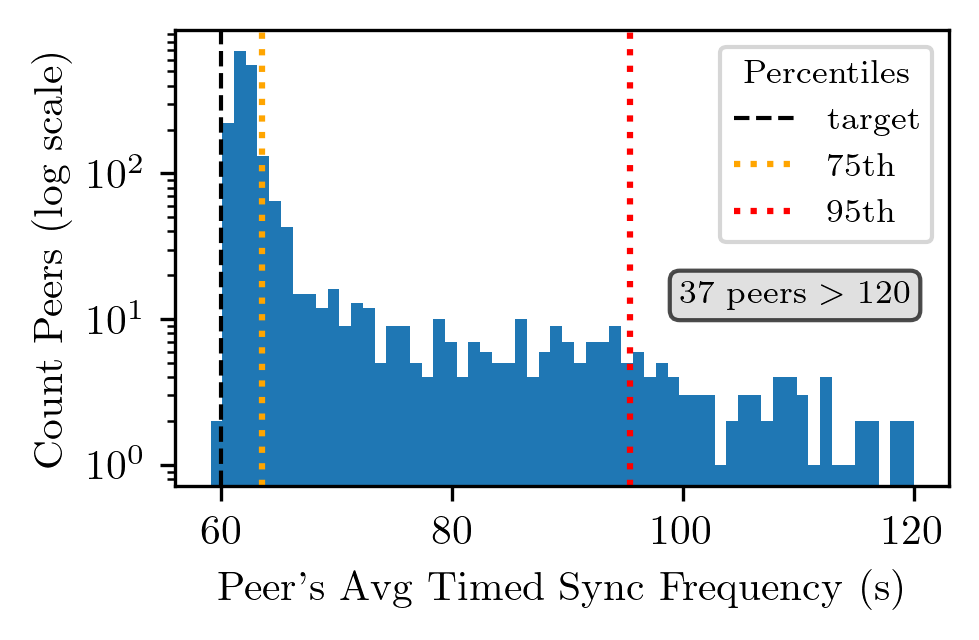

--------------------------------------------------
Connection's Avg Timed Sync Frequency Analysis:
--------------------------------------------------
20263 individual connections: 68.17565811600056
Max: 628.0229926058392
Percentile distribution: 
    0.5th percentile: 62.19914859892474
    0.75th percentile: 63.53936615625
    0.9th percentile: 81.65379136863447
    0.95th percentile: 96.91542328853303
    0.99th percentile: 142.55469698133305


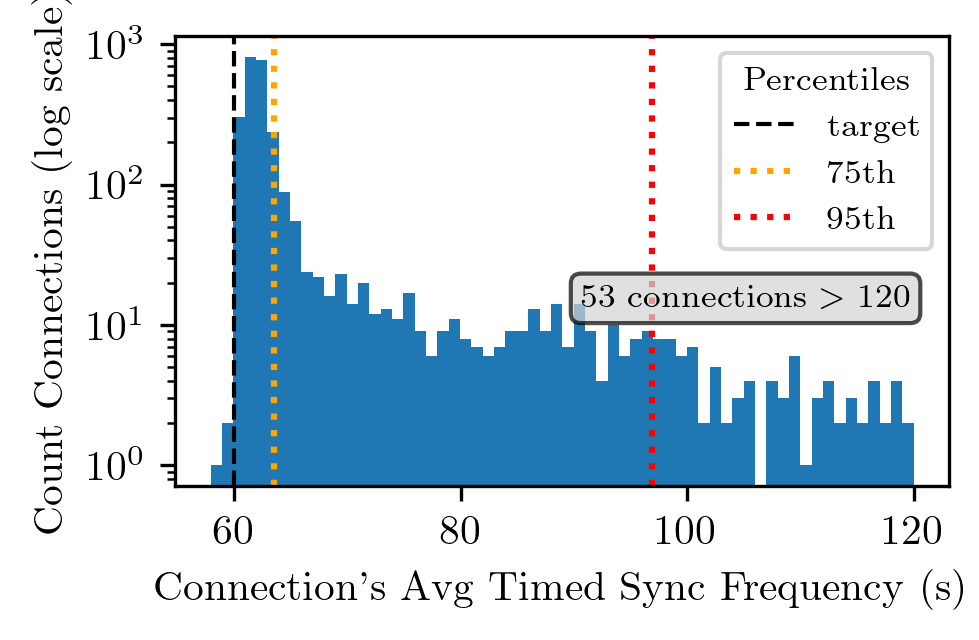

In [ ]:
def analyze_ts_latency(peer_packets_df, result_df):
    all_data = peer_packets_df.copy()
    all_data = all_data.sort_values(['source_ip', 'source_port', 'timestamp'])

    all_data['source_endpoint'] = all_data['source_ip'].astype(str) + ':' + all_data['source_port'].astype(str)
    all_data['source_endpoint_cat'] = all_data['source_endpoint'].astype('category')

    # shift to later compare current vs prev IP
    all_data['prev_endpoint'] = all_data['source_endpoint_cat'].shift(1)
    all_data['time_diff'] = all_data['timestamp'].diff().dt.total_seconds()

    # mask logic to identify breaks if IP changes, time is bigger 120s (idle), first row, handshake
    all_data['is_break'] = (
        (all_data['source_endpoint_cat'] != all_data['prev_endpoint']) |
        (all_data['time_diff'] > 120) |
        (all_data['time_diff'].isna()) |
        (all_data['command'] == '1001')
    )
    
    all_data['connection_id'] = all_data['is_break'].cumsum()

    # filter already for valid conns
    grouped = all_data.groupby('connection_id')
    connection_sizes = grouped.size()
    valid_conns = connection_sizes >= 2
    valid_conn_ids = valid_conns[valid_conns].index

    all_ts_diffs = []
    conn_info = []

    for conn_id in valid_conn_ids:
        conn = grouped.get_group(conn_id)
        commands = np.array(conn['command'])
        monero_flags = np.array(conn['monero_flags'])
        timestamps = np.array(conn['timestamp'])
        if len(commands) > 1: 
            duration = timestamps[-1]-timestamps[0]
        else:
            duration = None
        ts_mask = (commands == '1002') & (monero_flags == '1')
        ts_series = pd.Series(timestamps[ts_mask])
        
        # Get source IP for this connection
        source_ip = conn['source_ip'].iloc[0]

        if len(ts_series) > 2:
            differences = ts_series.diff().dt.total_seconds().dropna()
            all_ts_diffs.extend(differences)
            latency = differences.mean()

            # Append connection info for efficient processing
            conn_info.append({'source_ip': source_ip, 'ts_latency': latency, 'duration': duration})
        else:
            # If no valid latency, still record the IP with None
            conn_info.append({'source_ip': source_ip, 'ts_latency': None, 'duration': duration})

    conn_df = pd.DataFrame(conn_info)

    latency_by_ip = conn_df.groupby('source_ip')['ts_latency'].mean()

    result_df['ts_latency'] = result_df['source_ip'].map(latency_by_ip)
    
    quantiles = [0.50, 0.75, 0.90, 0.95, 0.99]
    print('-'*50)
    print(f"Average connection duration: {conn_df['duration'].mean()}")
    print(f"-"*50)
    print(f"Peer\'s Avg Timed Sync Frequency Analysis:")
    print(f"-"*50)
    print(f"Averaged over {len(result_df['ts_latency'])} individual connections: {np.mean(result_df['ts_latency'])}")
    print(f"Max: {result_df['ts_latency'].max()}")
    print(f"Percentile distribution: ")
    for quantile in quantiles:
        print(f"    {quantile}th percentile: {result_df['ts_latency'].quantile(quantile)}")

    set_plt_latex_format()
    plt.figure(figsize=(3.13, 2), dpi=300)
    plt.hist(result_df['ts_latency'], range=(result_df['ts_latency'].min(), 120), bins=int(120-result_df['ts_latency'].min()), log=True)
    #plt.axvline(result_df['ts_latency'].quantile(0.5), color='orange', linestyle='--', label='50th')
    plt.axvline(60, color='black', linestyle='--', label='target', linewidth=1)
    plt.axvline(result_df['ts_latency'].quantile(0.75), color='orange', linestyle=':', label='75th')
    plt.axvline(result_df['ts_latency'].quantile(0.95), color='red', linestyle=':', label='95th')
    outlier_count = sum(x > 120 for x in result_df['ts_latency'])
    plt.text(0.95, 0.45, f'{outlier_count} peers $>$ 120', fontsize=8,
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    plt.xlabel(f'Peer\'s Avg Timed Sync Frequency (s)')
    plt.xticks([60,80,100,120])
    plt.ylabel(f'Count Peers (log scale)')
    plt.legend(title='Percentiles', fontsize=8, title_fontsize=8)
    plt.tight_layout(pad=0.2)
    #plt.savefig('results/graphs/ts_latency_dist.pdf')
    plt.show()

    print(f"-"*50)
    print(f"Connection\'s Avg Timed Sync Frequency Analysis:")
    print(f"-"*50)
    print(f"{len(conn_df['ts_latency'])} individual connections: {np.mean(conn_df['ts_latency'])}")
    print(f"Max: {conn_df['ts_latency'].max()}")
    print(f"Percentile distribution: ")
    for quantile in quantiles:
        print(f"    {quantile}th percentile: {conn_df['ts_latency'].quantile(quantile)}")
    plt.figure(figsize=(3.13, 2), dpi=300)
    plt.hist(conn_df['ts_latency'], range=(conn_df['ts_latency'].min(), 120), bins=int(120-conn_df['ts_latency'].min()), log=True)
    #plt.axvline(result_df['ts_latency'].quantile(0.5), color='orange', linestyle='--', label='50th')
    plt.axvline(60, color='black', linestyle='--', label='target', linewidth=1)
    plt.axvline(conn_df['ts_latency'].quantile(0.75), color='orange', linestyle=':', label='75th')
    plt.axvline(conn_df['ts_latency'].quantile(0.95), color='red', linestyle=':', label='95th')
    outlier_count = sum(x > 120 for x in conn_df['ts_latency'])
    plt.text(0.95, 0.45, f'{outlier_count} connections $>$ 120', fontsize=8,
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    plt.xlabel(f'Connection\'s Avg Timed Sync Frequency (s)')
    plt.xticks([60,80,100,120])
    plt.ylabel(f'Count Connections (log scale)')
    plt.legend(title='Percentiles', fontsize=8, title_fontsize=8)
    plt.tight_layout(pad=0.2)
    #plt.savefig('results/graphs/ts_latency_dist.pdf')
    plt.show()
    
    
    return result_df

result_df = analyze_ts_latency(peer_packets_df, result_df)


In [8]:
high_lat = result_df[result_df['ts_latency'] > 120]
#print(high_lat)


Ping Analysis:
32978 connections.
Percentile distribution of number of Pings sent per connection: 
    0.5th percentile: 1.0
    0.75th percentile: 1.0
    0.9th percentile: 1.0
    0.95th percentile: 1.0
    0.99th percentile: 28.0
Percentile distribution of frequency of Pings if more than one is sent: 
    0.5th percentile: 6.07677185185185
    0.75th percentile: 6.156730788461539
    0.9th percentile: 8.073864150746271
    0.95th percentile: 10.09457264447439
    0.99th percentile: 51.52145067999989


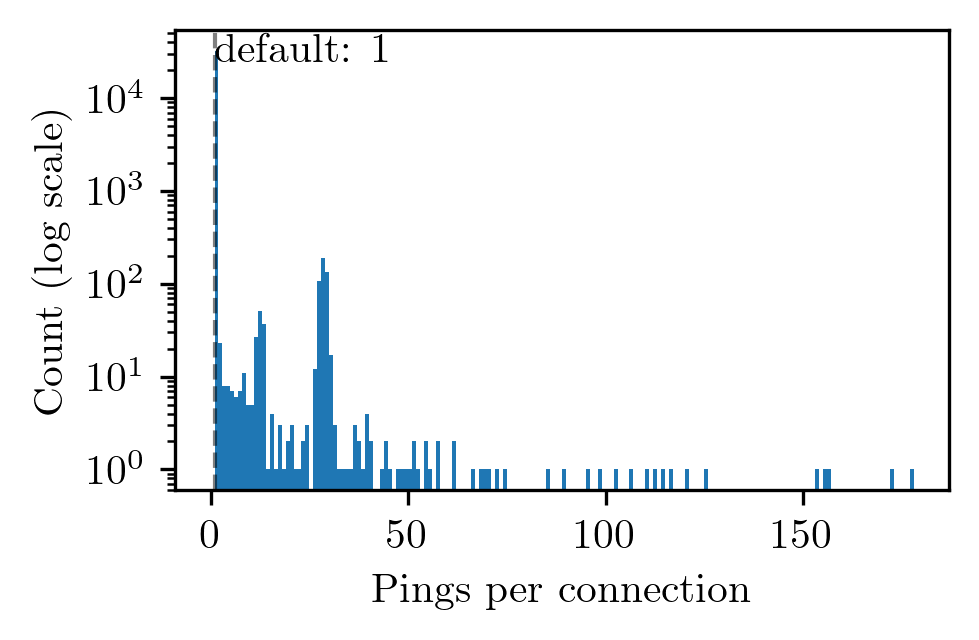

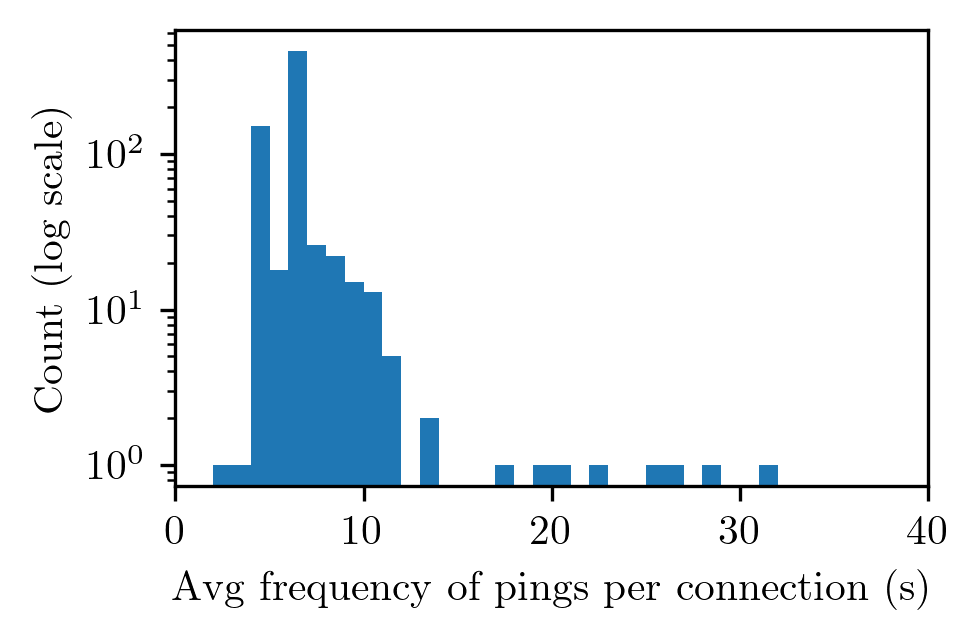

In [64]:
def analyze_ping_connections(peer_packets_df, result_df):
    # for connection visualization stick to IP and dont split the connection for repeated Handshakes (known pattern)
    all_data = peer_packets_df.copy()
    all_data = all_data.sort_values(['source_ip', 'source_port', 'timestamp'])

    all_data['source_endpoint'] = all_data['source_ip'].astype(str) + ':' + all_data['source_port'].astype(str)
    all_data['source_endpoint_cat'] = all_data['source_endpoint'].astype('category')

    # shift to later compare current vs prev IP
    all_data['prev_endpoint'] = all_data['source_endpoint_cat'].shift(1)
    all_data['time_diff'] = all_data['timestamp'].diff().dt.total_seconds()

    # mask logic to identify breaks if IP changes, time is bigger 120s (idle), first row, handshake
    all_data['is_break'] = (
        (all_data['source_endpoint_cat'] != all_data['prev_endpoint']) | 
        (all_data['time_diff'] > 120) | 
        (all_data['time_diff'].isna()) #| 
        #(all_data['command'] == '1001')
    )
    all_data['connection_id'] = all_data['is_break'].cumsum()

    # filter already for valid conns
    grouped = all_data.groupby('connection_id')
    connection_sizes = grouped.size()
    valid_conns = connection_sizes >= 1
    valid_conn_ids = valid_conns[valid_conns].index
    
    conn_info = []

    for conn_id in valid_conn_ids:
        conn = grouped.get_group(conn_id)
        commands = np.array(conn['command'])
        monero_flags = np.array(conn['monero_flags'])
        timestamps = np.array(conn['timestamp'])
        source_ip = conn['source_ip'].iloc[0]

        conn_row = {
            'source_ip': source_ip,
            'total_pings': 1,
            'ping_frequency': None
        }

        # Ping Analysis
        ping_mask = (commands == '1003')
        ping_timestamps = timestamps[ping_mask]
        if len(ping_timestamps) > 1:
            ping_series = pd.Series(ping_timestamps)
            ping_differences = ping_series.diff().dt.total_seconds().dropna()

            conn_row['total_pings'] = len(ping_timestamps)
            conn_row['ping_frequency'] = ping_differences.mean()
        
        conn_info.append(conn_row)
    
    conn_df = pd.DataFrame(conn_info)

    ping_frequency_by_ip = conn_df.groupby('source_ip')['ping_frequency'].mean()
    result_df['ping_frequency'] = result_df['source_ip'].map(ping_frequency_by_ip)
    pings_by_ip = conn_df.groupby('source_ip')['total_pings'].sum()
    result_df['total_pings'] = result_df['source_ip'].map(pings_by_ip)
    
    # Ping Plots
    quantiles = [0.50, 0.75, 0.90, 0.95, 0.99]
    print(f"\nPing Analysis:")
    print(f"{len(conn_df['total_pings'])} connections.")
    print(f"Percentile distribution of number of Pings sent per connection: ")
    for quantile in quantiles:
        print(f"    {quantile}th percentile: {conn_df['total_pings'].quantile(quantile)}")
    print(f"Percentile distribution of frequency of Pings if more than one is sent: ")
    for quantile in quantiles:
        print(f"    {quantile}th percentile: {conn_df['ping_frequency'].quantile(quantile)}")
    
    plt.figure(figsize=(3.13, 2), dpi=300)
    plt.hist(conn_df['total_pings'], bins=conn_df['total_pings'].max(), range=(0, conn_df['total_pings'].max()), log=True)
    #plt.xlim(0, 35)
    plt.axvline(1, color='black', linestyle='--', linewidth=1, alpha=0.5, label='default')
    plt.text(1.05, plt.ylim()[1]*0.9, 'default: 1', verticalalignment='top', fontsize=10)
    #plt.axvline(result_df['total_pings'].quantile(0.9), color='orange', linestyle=':', label='90th')
    #plt.axvline(result_df['total_pings'].quantile(0.95), color='red', linestyle=':', label='95th')

    outlier_count = sum(x > 35 for x in conn_df['total_pings'])
    #if outlier_count == 1:
    #    plt.text(0.55, 0.93, f'{outlier_count} connection with {conn_df['total_pings'].max()} pings', fontsize=10,
    #         transform=plt.gca().transAxes, ha='right', va='top',
    #         bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    #elif outlier_count > 0:
    #    plt.text(0.55, 0.93, f'{outlier_count} connections $>$ 40', fontsize=10,
    #         transform=plt.gca().transAxes, ha='right', va='top',
    #         bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    plt.xlabel(f'Pings per connection')
    plt.ylabel(f'Count (log scale)')
    #plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
    plt.tight_layout(pad=0.2)
    plt.show()
    
    plt.figure(figsize=(3.13, 2), dpi=300)
    plt.hist(conn_df['ping_frequency'], bins=40, range=(0, 40), log=True)
    plt.xlim(0, 40)
    #plt.axvline(result_df['ping_frequency'].quantile(0.95), color='green', linestyle=':', label='95th')
    #plt.axvline(result_df['ping_frequency'].quantile(0.9), color='red', linestyle=':', label='90th')
    
    outlier_count = sum(x > 120 for x in conn_df['ping_frequency'])
    if outlier_count > 0:
        plt.text(0.55, 0.93, f'{outlier_count} outliers $>$ 120', fontsize=10,
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    plt.xlabel(f'Avg frequency of pings per connection (s)')
    plt.ylabel(f'Count (log scale)')
    #plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
    plt.tight_layout(pad=0.2)
    plt.show()

    return result_df, conn_df
    
result_df, conn_df = analyze_ping_connections(peer_packets_df, result_df)

--------------------------------------------------
Handshake flooding analysis
--------------------------------------------------
Top 5 IPs with most handshakes: 
source_ip
162.218.65.219     20132
146.70.119.59        162
102.219.9.57          61
185.193.226.35        48
217.155.180.118       48
dtype: int64


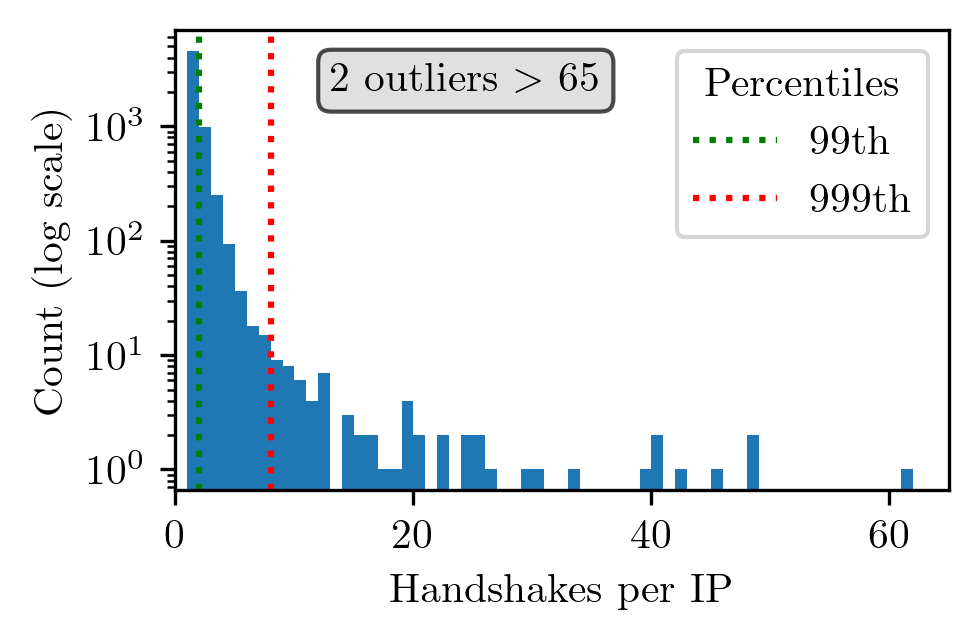

111.84444444444445


In [ ]:
def analyze_handshake_flooding(peer_packets_df, result_df):
    cmd_1001_data = peer_packets_df[peer_packets_df['command'] == '1001'].copy()
    cmd_1001_data = cmd_1001_data.sort_values(['source_ip', 'timestamp'])
    
    ip_rates = {}
    window_duration = pd.Timedelta(minutes=8)
    
    for source_ip in cmd_1001_data['source_ip'].unique():
        ip_data = cmd_1001_data[cmd_1001_data['source_ip'] == source_ip]
        timestamps = ip_data['timestamp'].values
        
        if len(timestamps) < 2:
            ip_rates[source_ip] = 0
            continue
            
        window_counts = []
        i = 0
        
        while i < len(timestamps):
            window_start = timestamps[i]
            window_end = window_start + window_duration
            
            count = 0
            j = i
            while j < len(timestamps) and timestamps[j] < window_end:
                count += 1
                j += 1
            
            window_counts.append(count)
            
            # find next window
            next_window_start = window_start + window_duration
            # if there is one
            while i < len(timestamps) and timestamps[i] < next_window_start:
                i += 1
                
            # if not, break
            if i >= len(timestamps):
                break
        
        # Average rate across all windows
        avg_rate = np.mean(window_counts) if window_counts else 0
        ip_rates[source_ip] = avg_rate
    
    result_df['1001_window_rate'] = result_df['source_ip'].map(ip_rates)

    all_data = peer_packets_df.copy()
    command_counts = all_data[all_data['command'] == '1001'].groupby('source_ip').size()
    
    result_df['total_handshakes'] = result_df['source_ip'].map(command_counts)

    print('-'*50)
    print(f"Handshake flooding analysis")
    print('-'*50)
    print("Top 5 IPs with most handshakes: ")
    print(command_counts.nlargest(5))
    print("Top 5 IPs with most handshakes per 20 minutes: ")


    # Handshake Plots
    plt.figure(figsize=(3.13, 2), dpi=300)
    plt.hist(command_counts.values, bins=65, range=(0, 65), log=True)
    plt.xlim(0, 65)
    plt.axvline(np.percentile(command_counts.values, 90), color='green', linestyle=':', label='99th')
    plt.axvline(np.percentile(command_counts.values, 99), color='red', linestyle=':', label='999th')

    outlier_count = sum(x > 65 for x in command_counts.values)
    plt.text(0.55, 0.93, f'{outlier_count} outliers $>$ 65', fontsize=10,
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    plt.xlabel(f'Handshakes per IP')
    plt.ylabel(f'Count (log scale)')
    plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
    plt.tight_layout(pad=0.2)
    plt.show()
    
    return result_df

result_df = analyze_handshake_flooding(peer_packets_df, result_df)


--------------------------------------------------
Handshake and Ping flooding analysis
--------------------------------------------------
Top 5 IPs with most handshakes: 
source_ip
162.218.65.219     20132
146.70.119.59        162
102.219.9.57          61
185.193.226.35        48
217.155.180.118       48
dtype: int64


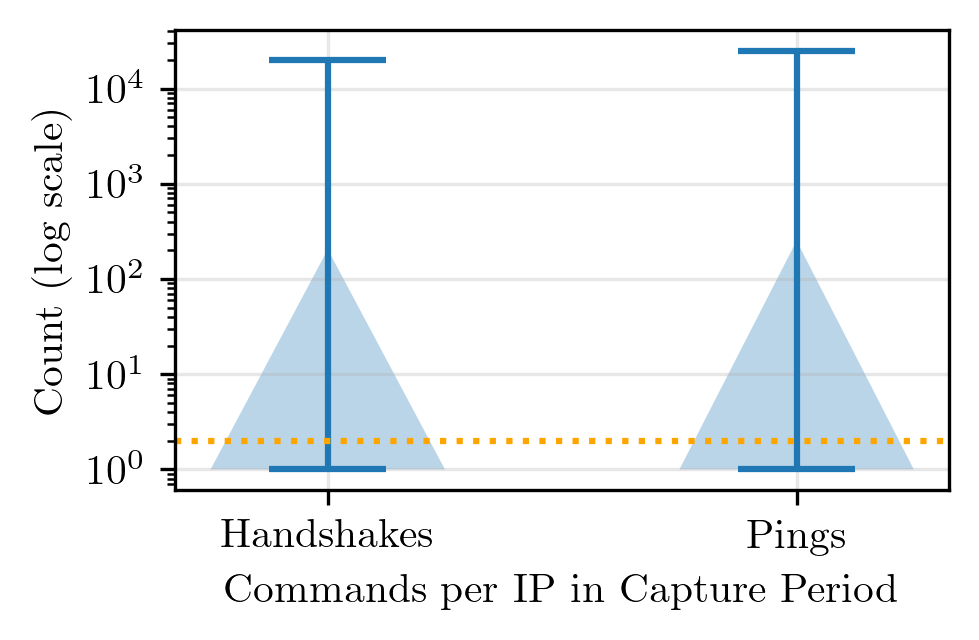

In [ ]:
# TEST
def analyze_handshake_flooding(peer_packets_df, result_df):
    
    all_data = peer_packets_df.copy()
    command_counts = all_data[all_data['command'] == '1001'].groupby('source_ip').size()
    
    result_df['total_handshakes'] = result_df['source_ip'].map(command_counts)

    print('-'*50)
    print(f"Handshake and Ping flooding analysis")
    print('-'*50)
    print("Top 5 IPs with most handshakes: ")
    print(command_counts.nlargest(5))

    # Handshake Plots
    fig, ax = plt.subplots(figsize=(8, 6))

    # Create violin plot with custom colors
    parts = ax.violinplot([result_df['total_handshakes'], result_df['total_pings']], 
                          positions=[1, 2], widths=0.6)
    
    # Customize violin colors
    colors = ['#3498db', '#e74c3c']  # Blue and red
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_alpha(0.7)
        pc.set_edgecolor('black')
        pc.set_linewidth(1)
    
    # Style the other elements
    parts['cbars'].set_color('black')
    parts['cmins'].set_color('black')
    parts['cmaxes'].set_color('black')
    
    # Set log scale and labels
    ax.set_yscale('log')
    ax.set_ylabel('Count (log scale)', fontsize=12)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Handshakes', 'Pings'], fontsize=12)
    
    # Add grid and styling
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title('Distribution of Handshakes vs Pings', fontsize=14, pad=20)
    
    plt.tight_layout()
    plt.show()

    return result_df

result_df = analyze_handshake_flooding(peer_packets_df, result_df)


In [ ]:
def analyze_handshake_flooding(peer_packets_df, result_df):
    cmd_1001_data = peer_packets_df[peer_packets_df['command'] == '1001'].copy()
    cmd_1001_data = cmd_1001_data.sort_values(['source_ip', 'timestamp'])
    
    ip_rates = {}
    window_duration = pd.Timedelta(minutes=8)
    
    for source_ip in cmd_1001_data['source_ip'].unique():
        ip_data = cmd_1001_data[cmd_1001_data['source_ip'] == source_ip]
        timestamps = ip_data['timestamp'].values
        
        if len(timestamps) < 2:
            ip_rates[source_ip] = 0
            continue
            
        window_counts = []
        i = 0
        
        while i < len(timestamps):
            window_start = timestamps[i]
            window_end = window_start + window_duration
            
            count = 0
            j = i
            while j < len(timestamps) and timestamps[j] < window_end:
                count += 1
                j += 1
            
            window_counts.append(count)
            
            # find next window
            next_window_start = window_start + window_duration
            # if there is one
            while i < len(timestamps) and timestamps[i] < next_window_start:
                i += 1
                
            # if not, break
            if i >= len(timestamps):
                break
        
        # Average rate across all windows
        avg_rate = np.mean(window_counts) if window_counts else 0
        ip_rates[source_ip] = avg_rate
    
    result_df['1001_window_rate'] = result_df['source_ip'].map(ip_rates)

    all_data = peer_packets_df.copy()
    command_counts = all_data[all_data['command'] == '1001'].groupby('source_ip').size()
    
    result_df['total_handshakes'] = result_df['source_ip'].map(command_counts)

    print('-'*50)
    print(f"Handshake and Ping flooding analysis")
    print('-'*50)
    print("Top 5 IPs with most handshakes: ")
    print(command_counts.nlargest(5))


    # Handshake Plots
    plt.figure(figsize=(3.13, 2), dpi=300)
    plt.hist(command_counts.values, bins=65, range=(0, 65), log=True)
    plt.xlim(0, 65)
    
    outlier_count = sum(x > 65 for x in command_counts.values)
    plt.text(0.55, 0.93, f'{outlier_count} outliers $>$ 65', fontsize=10,
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    plt.xlabel(f'Handshakes per IP')
    plt.ylabel(f'Count (log scale)')
    plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
    plt.tight_layout(pad=0.2)
    plt.show()
    
    return result_df

result_df = analyze_handshake_flooding(peer_packets_df, result_df)


source_ip
162.218.65.219     20132
146.70.119.59        162
102.219.9.57          61
185.193.226.35        48
217.155.180.118       48
194.164.32.12         45
73.63.192.88          42
35.151.225.151        40
77.25.140.106         40
74.75.42.138          39
76.197.211.43         33
79.215.240.189        30
164.160.4.60          29
193.19.207.231        26
217.119.77.73         25
dtype: int64

Handshake Analysis:
6047 connections.


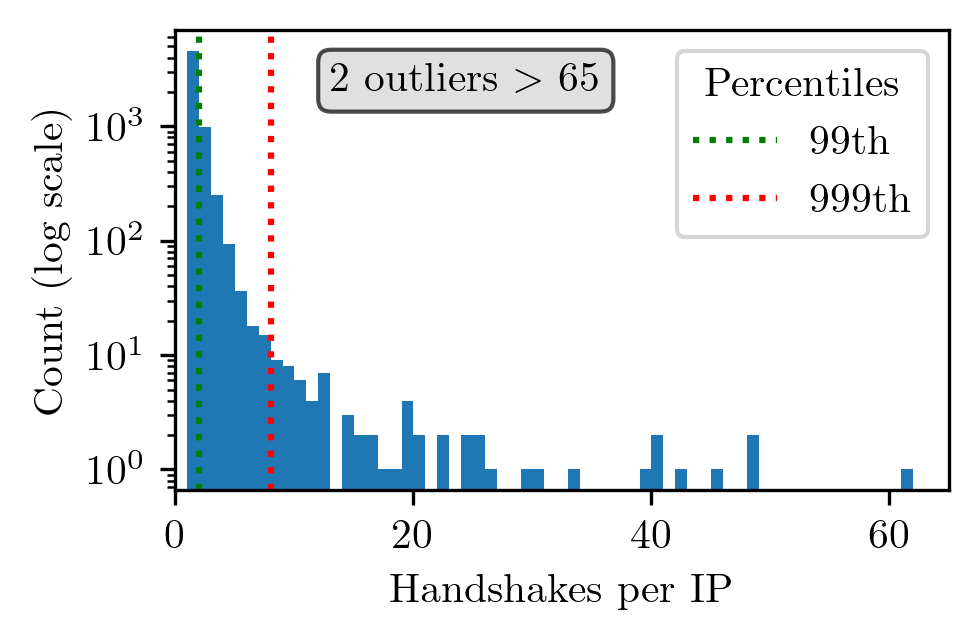

In [54]:
def analyze_handshakes(peer_packets_df, result_df):
    # for connection visualization stick to IP and dont split the connection for repeated Handshakes (known pattern)
    all_data = peer_packets_df.copy()
    all_data = all_data.sort_values(['source_ip', 'source_port', 'timestamp'])

    all_data['source_endpoint'] = all_data['source_ip'].astype(str) + ':' + all_data['source_port'].astype(str)
    all_data['source_endpoint_cat'] = all_data['source_endpoint'].astype('category')

    command_counts = all_data[all_data['command'] == '1001'].groupby('source_ip').size()
    
    print(command_counts.nlargest(15))
    # Handshake Plots
    quantiles = [0.50, 0.75, 0.90, 0.95, 0.99, 0.999]
    print(f"\nHandshake Analysis:")
    print(f"{len(command_counts.values)} connections.")
    
    plt.figure(figsize=(3.13, 2), dpi=300)
    plt.hist(command_counts.values, bins=65, range=(0, 65), log=True)
    plt.xlim(0, 65)
    plt.axvline(np.percentile(command_counts.values, 90), color='green', linestyle=':', label='99th')
    plt.axvline(np.percentile(command_counts.values, 99), color='red', linestyle=':', label='999th')

    outlier_count = sum(x > 65 for x in command_counts.values)
    plt.text(0.55, 0.93, f'{outlier_count} outliers $>$ 65', fontsize=10,
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    plt.xlabel(f'Handshakes per IP')
    plt.ylabel(f'Count (log scale)')
    plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
    plt.tight_layout(pad=0.2)
    plt.show()

    return result_df, command_counts
    
result_df, command_counts = analyze_handshakes(peer_packets_df, result_df)

In [ ]:
def analyze_connections():
    all_data = peer_packets_df.copy()
    all_data = all_data.sort_values(['source_ip', 'source_port', 'timestamp'])

    all_data['source_endpoint'] = all_data['source_ip'].astype(str) + ':' + all_data['source_port'].astype(str)
    all_data['source_endpoint_cat'] = all_data['source_endpoint'].astype('category')

    # shift to later compare current vs prev IP
    all_data['prev_endpoint'] = all_data['source_endpoint_cat'].shift(1)
    all_data['time_diff'] = all_data['timestamp'].diff().dt.total_seconds()

    # mask logic to identify breaks if IP changes, time is bigger 120s (idle), first row, handshake
    all_data['is_break'] = (
        (all_data['source_endpoint_cat'] != all_data['prev_endpoint']) | 
        (all_data['time_diff'] > 120) | 
        (all_data['time_diff'].isna()) | 
        (all_data['command'] == '1001')
    )
    all_data['connection_id'] = all_data['is_break'].cumsum()

    # filter already for valid conns
    grouped = all_data.groupby('connection_id')
    connection_sizes = grouped.size()
    valid_conns = connection_sizes >= 1
    valid_conn_ids = valid_conns[valid_conns].index

    conn_info = []

    for conn_id in valid_conn_ids:
        conn = grouped.get_group(conn_id)
        source_ip = conn['source_ip'].iloc[0]
        conn_row = {
            'source_ip': source_ip,
        }

        command_counts = conn['command'].value_counts()
        conn_row.update(command_counts.to_dict())

        commands = np.array(conn['command'])
        monero_flags = np.array(conn['monero_flags'])
        timestamps = np.array(conn['timestamp'])
        
        duration = timestamps[-1] - timestamps[0]
        conn_row['duration'] = duration / np.timedelta64(1, 's')

        base_mask = (commands == '1001') | (commands == '1002') | (commands == '1003')
        

        conn_info.append(conn_row)
    
    conn_df = pd.DataFrame(conn_info)
    return conn_df

conn_df = analyze_connections()
    

In [ ]:
def analyze_connections(peer_packets_df, result_df):
    # for connection visualization stick to IP and dont split the connection for repeated Handshakes (known pattern)
    all_data = peer_packets_df.copy()
    all_data = all_data.sort_values(['source_ip', 'timestamp'])

    all_data['source_ip_cat'] = all_data['source_ip'].astype('category')

    # shift to later compare current vs prev IP
    all_data['prev_ip'] = all_data['source_ip_cat'].shift(1) 
    all_data['time_diff'] = all_data['timestamp'].diff().dt.total_seconds()

    # mask logic to identify breaks if IP changes, time is bigger 120s (idle connection), or first row
    all_data['is_break'] = (all_data['source_ip_cat'] != all_data['prev_ip']) | (all_data['time_diff'] > 120) | (all_data['time_diff'].isna())
    all_data['connection_id'] = all_data['is_break'].cumsum()

    # filter already for valid conns
    grouped = all_data.groupby('connection_id')
    connection_sizes = grouped.size()
    valid_conns = connection_sizes >= 1
    valid_conn_ids = valid_conns[valid_conns].index
    
    conn_info = []

    for conn_id in valid_conn_ids:
        conn = grouped.get_group(conn_id)
        commands = np.array(conn['command'])
        monero_flags = np.array(conn['monero_flags'])
        timestamps = np.array(conn['timestamp'])
        source_ip = conn['source_ip'].iloc[0]

        conn_row = {
            'source_ip': source_ip,
            'total_pings': 1,
            'ping_frequency': 0,
            'total_handshakes': 1,
            'handshake_frequency': 0
        }

        # Ping Analysis
        ping_mask = (commands == '1003')
        ping_timestamps = timestamps[ping_mask]
        if len(ping_timestamps) > 1:
            ping_series = pd.Series(ping_timestamps)
            ping_differences = ping_series.diff().dt.total_seconds().dropna()

            conn_row['total_pings'] = len(ping_timestamps)
            conn_row['ping_frequency'] = ping_differences.mean()
        
        # Handshake Analysis
        handshake_mask = (commands == '1001')
        handshake_timestamps = timestamps[handshake_mask]
        if len(handshake_timestamps) > 1:
            handshake_series = pd.Series(handshake_timestamps)
            handshake_diffs = handshake_series.diff().dt.total_seconds().dropna()

            conn_row['total_handshakes'] = len(handshake_timestamps)
            conn_row['handshake_frequency'] = handshake_diffs.mean()
        
        conn_info.append(conn_row)
    
    conn_df = pd.DataFrame(conn_info)

    ping_frequency_by_ip = conn_df.groupby('source_ip')['ping_frequency'].mean()
    result_df['ping_frequency'] = result_df['source_ip'].map(ping_frequency_by_ip)
    pings_by_ip = conn_df.groupby('source_ip')['total_pings'].max()
    result_df['total_pings'] = result_df['source_ip'].map(pings_by_ip)

    handshake_frequency_by_ip = conn_df.groupby('source_ip')['handshake_frequency'].mean()
    handshakes_by_ip = conn_df.groupby('source_ip')['total_handshakes'].max()
    result_df['handshake_frequency'] = result_df['source_ip'].map(handshake_frequency_by_ip)
    result_df['total_handshakes'] = result_df['source_ip'].map(handshakes_by_ip)
    
    # Ping Plots
    quantiles = [0.50, 0.75, 0.90, 0.95, 0.99]
    print(f"\nPing Analysis:")
    print(f"{len(result_df['total_pings'])} connections.")
    print(f"Percentile distribution of number of Pings sent per connection: ")
    for quantile in quantiles:
        print(f"    {quantile}th percentile: {result_df['total_pings'].quantile(quantile)}")
    print(f"Percentile distribution of frequency of Pings if more than one is sent: ")
    for quantile in quantiles:
        print(f"    {quantile}th percentile: {result_df['ping_frequency'].quantile(quantile)}")
    
    plt.figure(figsize=(3.13, 2), dpi=300)
    plt.hist(result_df['total_pings'], bins=40, range=(0, 40), log=True)
    plt.xlim(0, 40)
    plt.axvline(result_df['total_pings'].quantile(0.95), color='green', linestyle=':', label='95th')
    plt.axvline(result_df['total_pings'].quantile(0.9), color='red', linestyle=':', label='90th')

    outlier_count = sum(x > 40 for x in result_df['total_pings'])
    plt.text(0.55, 0.93, f'{outlier_count} outliers $>$ 40', fontsize=10,
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    plt.xlabel(f'Pings per connection')
    plt.ylabel(f'Count (log scale)')
    plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
    plt.tight_layout(pad=0.2)
    plt.show()
    
    plt.figure(figsize=(3.13, 2), dpi=300)
    plt.hist(result_df['ping_frequency'], bins=120, range=(0, 120), log=True)
    plt.xlim(0, 120)
    plt.axvline(result_df['ping_frequency'].quantile(0.95), color='green', linestyle=':', label='95th')
    plt.axvline(result_df['ping_frequency'].quantile(0.9), color='red', linestyle=':', label='90th')
    
    outlier_count = sum(x > 120 for x in result_df['ping_frequency'])
    plt.text(0.55, 0.93, f'{outlier_count} outliers $>$ 120', fontsize=10,
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    plt.xlabel(f'Frequency of pings (s)')
    plt.ylabel(f'Count (log scale)')
    plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
    plt.tight_layout(pad=0.2)
    plt.show()

    # Handshake Plots
    quantiles = [0.50, 0.75, 0.90, 0.95, 0.99, 0.999]
    print(f"\nHandshake Analysis:")
    print(f"{len(result_df['total_handshakes'])} connections.")
    print(f"Percentile distribution of number of Handshakes sent per connection: ")
    for quantile in quantiles:
        print(f"    {quantile}th percentile: {result_df['total_handshakes'].quantile(quantile)}")
    print(f"Percentile distribution of frequency of Handshakes if more than one is sent: ")
    for quantile in quantiles:
        print(f"    {quantile}th percentile: {result_df['handshake_frequency'].quantile(quantile)}")
    
    plt.figure(figsize=(3.13, 2), dpi=300)
    plt.hist(result_df['total_handshakes'], bins=40, range=(0, 40), log=True)
    plt.xlim(0, 40)
    plt.axvline(result_df['total_handshakes'].quantile(0.99), color='green', linestyle=':', label='99th')
    plt.axvline(result_df['total_handshakes'].quantile(0.999), color='red', linestyle=':', label='999th')

    outlier_count = sum(x > 40 for x in result_df['total_handshakes'])
    plt.text(0.55, 0.93, f'{outlier_count} outliers $>$ 40', fontsize=10,
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    plt.xlabel(f'Handshakes per connection')
    plt.ylabel(f'Count (log scale)')
    plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
    plt.tight_layout(pad=0.2)
    plt.show()
    
    plt.figure(figsize=(3.13, 2), dpi=300)
    plt.hist(result_df['handshake_frequency'], bins=120, range=(0, 120), log=True)
    plt.xlim(0, 120)
    plt.axvline(result_df['handshake_frequency'].quantile(0.50), color='green', linestyle=':', label='50th')
    plt.axvline(result_df['handshake_frequency'].quantile(0.75), color='red', linestyle=':', label='75th')
    
    outlier_count = sum(x > 120 for x in result_df['handshake_frequency'])
    plt.text(0.55, 0.93, f'{outlier_count} outliers $>$ 120', fontsize=10,
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    plt.xlabel(f'Frequency of handshakes (s)')
    plt.ylabel(f'Count (log scale)')
    plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
    plt.tight_layout(pad=0.2)
    plt.show()

    return result_df
    
result_df = analyze_connections(peer_packets_df, result_df)



# Peer Lists per Peer
- all peer lists of a peer aggregated

In [ ]:
unique_peers_by_source = peers_df.groupby('source_ip')['ip'].apply(lambda x: x.unique().tolist()).reset_index()
unique_peers_by_source.columns = ['source_ip', 'unique_peer_ips']
#print(unique_peers_by_source.head())

unique_peers_by_source['peer_count'] = unique_peers_by_source['unique_peer_ips'].apply(len)
unique_peers_by_source = unique_peers_by_source[unique_peers_by_source['peer_count'] > 250]

# Analyze sizes
peer_counts = unique_peers_by_source.set_index('source_ip')['peer_count']

# Convert to dict for easier access
peer_sets = {row['source_ip']: set(row['unique_peer_ips']) 
            for _, row in unique_peers_by_source.iterrows()}

# Calculate pairwise overlaps
overlaps = []
for source1, source2 in combinations(peer_sets.keys(), 2):
   intersection = len(peer_sets[source1] & peer_sets[source2])
   union = len(peer_sets[source1] | peer_sets[source2])
   jaccard = intersection / union if union > 0 else 0
   
   overlaps.append({
       'source1': source1, 'source2': source2,
       'intersection': intersection, 'jaccard_similarity': jaccard,
       'union': union
   })

overlap_df = pd.DataFrame(overlaps)

max_sim_by_ip = overlap_df.groupby('source1')['jaccard_similarity'].max()
result_df['max_pl_sim'] = result_df['source_ip'].map(max_sim_by_ip)

print(f"\nHighest overlaps:")
print(overlap_df.nlargest(5, 'intersection')[['source1', 'source2', 'intersection', 'union', 'jaccard_similarity']])
#print(f"\nSmallest overlaps:")
#print(overlap_df.nsmallest(5, 'intersection')[['source1', 'source2', 'intersection', 'jaccard_similarity']])
quantiles = [0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999, 0.9999]
for quantile in quantiles:
    print(f"{quantile}th percentile: {overlap_df['jaccard_similarity'].quantile(quantile)}")
print(f"\nHighest overlaps:")
print(overlap_df.nlargest(15, 'intersection')[['source1', 'source2', 'intersection', 'jaccard_similarity']])

In [ ]:
SIMILARITY_THRESHOLD = result_df['max_pl_sim'].quantile(0.95)
high_sim_pairs = overlap_df[overlap_df['jaccard_similarity'] >= SIMILARITY_THRESHOLD].copy()
#print(high_sim_pairs.head())

groups = []

for _, row in high_sim_pairs.iterrows():
    source1, source2 = row['source1'], row['source2']
    sim = row['jaccard_similarity']

    found_group = None
    for group in groups:
        if source1 in group['sources'] or source2 in group['sources']:
            found_group = group
            break
    
    if not found_group is None:
        found_group['sources'].add(source1)
        found_group['sources'].add(source2)
        found_group['similarities'].append(sim)
    else:
        groups.append({
            'sources': {source1, source2},
            'similarities': [sim]
        })
    
final_groups = []

for group in groups:
    if len(group['sources']) > 1:
        sources_list = list(group['sources'])
        similarities = group['similarities']
        final_groups.append({
            'sources': sources_list,
            'avg_similarity': sum(similarities) / len(similarities),
            'min_similarity': min(similarities),
            'max_similarity': max(similarities),
            'num_pairs': len(similarities)
        })

print(f"\nFound {len(final_groups)} similarity groups.\nMost similar groups: ")
source_to_group = {}
for i, group in enumerate(final_groups, 1):
    for source_ip in group['sources']:
        source_to_group[source_ip] = len(group['sources'])
    if len(group['sources']) > 2: #group['avg_similarity'] > 0.65:
        print(f"Group {i} ({len(group['sources'])} sources):")
        print(f"  Sources: {group['sources']}")
        print(f"  Avg similarity: {group['avg_similarity']:.3f}")
        print(f"  Range: {group['min_similarity']:.3f} - {group['max_similarity']:.3f}")
        print(f"  Based on {group['num_pairs']} pairs")

result_df[f'sim_group_{node}'] = result_df['source_ip'].map(source_to_group)

if final_groups:
    group_sizes = [len(group['sources']) for group in final_groups]
    avg_similarities = [group['avg_similarity'] for group in final_groups]
    print(f"\nOverall stats:")
    print(f"Total sources in groups: {sum(group_sizes)}")
    print(f"Average group size: {sum(group_sizes)/len(group_sizes):.1f}")
    print(f"Largest group: {max(group_sizes)} sources")
    print(f"Average of group similarities: {sum(avg_similarities)/len(avg_similarities):.3f}")

# Peer Lists Individually

In [ ]:
pl_by_source = peers_df.groupby('pl_identifier').agg({
    'ip': lambda x: x.tolist(),
    'source_ip': 'first',
    }).reset_index()
pl_by_source.columns = ['source_pl', 'peer_ips', 'source_ip']
#print(unique_peers_by_source.head())

pl_by_source['peer_count'] = pl_by_source['peer_ips'].apply(len)
pl_by_source = pl_by_source[pl_by_source['peer_count'] > 249]

peer_counts = pl_by_source.set_index('source_pl')['peer_count']

pl_counters = {row['source_pl']: Counter(row['peer_ips'])
               for _, row in pl_by_source.iterrows()}

source_ip_lookup = pl_by_source.set_index('source_pl')['source_ip'].to_dict()

overlaps = []
for source1, source2 in combinations(pl_counters.keys(), 2):
    counter1, counter2 = pl_counters[source1], pl_counters[source2]
    
    # Common IPs (intersection)
    common_ips = counter1 & counter2
    intersection_count = sum(common_ips.values())
    
    # Union with frequencies
    union_counter = counter1 | counter2
    union_count = sum(union_counter.values())
    
    jaccard = intersection_count / union_count if union_count > 0 else 0
   
    overlaps.append({
        'source1': source1, 
        'source2': source2,
        'source1_ip': source_ip_lookup[source1],
        'source2_ip': source_ip_lookup[source2],
        'intersection': intersection_count, 
        'jaccard_similarity': jaccard,
        'union': union_count
    })

overlap_df = pd.DataFrame(overlaps)
overlap_df.to_csv(f'results/node_results/{node}_pl_df.csv', index=False)

In [ ]:
quantiles = [0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999, 0.9999]
for quantile in quantiles:
    print(f"{quantile}th percentile: {overlap_df['jaccard_similarity'].quantile(quantile)}")
#print(f"\nHighest overlaps:")
#print(overlap_df.nlargest(15, 'jaccard_similarity')[['source1', 'source2', 'intersection', 'union', 'jaccard_similarity']])

plt.figure(figsize=(3.13, 2), dpi=300)
plt.hist(overlap_df['jaccard_similarity'], bins=100, log=True)
plt.axvline(overlap_df['jaccard_similarity'].quantile(0.50), color='green', linestyle=':', label='50th')
plt.axvline(overlap_df['jaccard_similarity'].quantile(0.99), color='orange', linestyle='--', label='99th')
plt.axvline(overlap_df['jaccard_similarity'].quantile(0.999), color='red', linestyle=':', label='999th')
plt.xlabel(f'Peer list similarities')
plt.ylabel(f'Count (log scale)')
plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
plt.tight_layout(pad=0.2)
plt.show()

high_sim_df = overlap_df[overlap_df['jaccard_similarity']>overlap_df['jaccard_similarity'].quantile(0.99)]
#print(high_sim_df.head(1))
#print(len(high_sim_df))
print(high_sim_df['source1_ip'].value_counts().head(20))

all_ips = pd.concat([
    high_sim_df['source1_ip'], 
    high_sim_df['source2_ip']
])

# Get value counts for all IPs
combined_ip_counts = all_ips.value_counts()

# Plot combined results
top_ips = combined_ip_counts.head(20)
others_count = combined_ip_counts.iloc[20:].sum()

plt.figure(figsize=(3.13, 2), dpi=300)
plt.bar(range(len(top_ips)), top_ips.values, label='Top 20 Individual IPs')
plt.bar(len(top_ips), others_count, color='red', 
        label=f'Others ({len(combined_ip_counts) - 20} IPs)')
plt.yscale('log')
plt.xlabel('IPs')
plt.ylabel('Count (log scale)')
#plt.title('IP Frequency')
plt.legend(fontsize=8)
plt.tight_layout(pad=0.2)
plt.show()

In [ ]:
pl_by_source = peers_df.groupby('pl_identifier').agg({
    'ip': lambda x: x.tolist(),
    'source_ip': 'first',
    }).reset_index()
pl_by_source.columns = ['source_pl', 'peer_ips', 'source_ip']
#print(unique_peers_by_source.head())

pl_by_source['peer_count'] = pl_by_source['peer_ips'].apply(len)
pl_by_source = pl_by_source[pl_by_source['peer_count'] > 249]

peer_counts = pl_by_source.set_index('source_pl')['peer_count']

pl_counters = {row['source_pl']: Counter(row['peer_ips'])
               for _, row in pl_by_source.iterrows()}

source_ip_lookup = pl_by_source.set_index('source_pl')['source_ip'].to_dict()

overlaps = []
for source1, source2 in combinations(pl_counters.keys(), 2):
    counter1, counter2 = pl_counters[source1], pl_counters[source2]
    source1_ip = source_ip_lookup[source1]
    source2_ip = source_ip_lookup[source2]
    if source1_ip == source2_ip:
        continue
    
    # Common IPs (intersection)
    common_ips = counter1 & counter2
    intersection_count = sum(common_ips.values())
    
    # Union with frequencies
    union_counter = counter1 | counter2
    union_count = sum(union_counter.values())
    
    jaccard = intersection_count / union_count if union_count > 0 else 0
   
    overlaps.append({
        'source1': source1, 
        'source2': source2,
        'source1_ip': source1_ip,
        'source2_ip': source2_ip,
        'intersection': intersection_count, 
        'jaccard_similarity': jaccard,
        'union': union_count
    })

overlap_df = pd.DataFrame(overlaps)

In [ ]:
quantiles = [0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999, 0.9999]
for quantile in quantiles:
    print(f"{quantile}th percentile: {overlap_df['jaccard_similarity'].quantile(quantile)}")
#print(f"\nHighest overlaps:")
#print(overlap_df.nlargest(15, 'jaccard_similarity')[['source1', 'source2', 'intersection', 'union', 'jaccard_similarity']])

plt.figure(figsize=(3.13, 2), dpi=300)
plt.hist(overlap_df['jaccard_similarity'], bins=100, log=True)
plt.axvline(overlap_df['jaccard_similarity'].quantile(0.50), color='green', linestyle=':', label='50th')
plt.axvline(overlap_df['jaccard_similarity'].quantile(0.99), color='orange', linestyle='--', label='99th')
plt.axvline(overlap_df['jaccard_similarity'].quantile(0.999), color='red', linestyle=':', label='999th')
plt.xlabel(f'Peer list similarities')
plt.ylabel(f'Count (log scale)')
plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
plt.tight_layout(pad=0.2)
plt.show()

high_sim_df = overlap_df[overlap_df['jaccard_similarity']>overlap_df['jaccard_similarity'].quantile(0.99)]
#print(high_sim_df.head(1))
#print(len(high_sim_df))
print(high_sim_df['source1_ip'].value_counts().head(20))

all_ips = pd.concat([
    high_sim_df['source1_ip'], 
    high_sim_df['source2_ip']
])

# Get value counts for all IPs
combined_ip_counts = all_ips.value_counts()

# Plot combined results
top_ips = combined_ip_counts.head(20)
others_count = combined_ip_counts.iloc[20:].sum()

plt.figure(figsize=(3.13, 2), dpi=300)
plt.bar(range(len(top_ips)), top_ips.values, label='Top 20 Individual IPs')
plt.bar(len(top_ips), others_count, color='red', 
        label=f'Others ({len(combined_ip_counts) - 20} IPs)')
plt.yscale('log')
plt.xlabel('IPs')
plt.ylabel('Count (log scale)')
#plt.title('IP Frequency')
plt.legend(fontsize=8)
plt.tight_layout(pad=0.2)
plt.show()

In [ ]:
print(pl_by_source.head())
for _, row in pl_by_source.iterrows(): 
    if row['source_ip'] == '138.199.6.205': 
        print(row)
        break

In [ ]:
# DIVERSITY
def calc_diversity(ip_list):
    subnets = set()
    valid_count = 0
    
    for ip in ip_list:
        try:
            subnet = str(ipaddress.IPv4Network(f"{ip}/24", strict=False).network_address) + "/24"
            subnets.add(subnet)
            valid_count += 1
        except:
            continue
    
    return len(subnets) / valid_count if valid_count > 0 else 0

pl_by_source['pl_diversity'] = pl_by_source['peer_ips'].apply(calc_diversity)

mean_pl_div = pl_by_source.groupby('source_ip')['pl_diversity'].mean()
result_df['avg_pl_diversity'] = result_df['source_ip'].map(mean_pl_div)



In [ ]:
plt.figure(figsize=(3.13, 2), dpi=300)
inverted_data = 1 - result_df['avg_pl_diversity']
plt.hist(inverted_data, bins=100, log=True)
plt.axvline(inverted_data.quantile(0.50), color='green', linestyle=':', label='50th')
plt.axvline(inverted_data.quantile(0.90), color='orange', linestyle='--', label='90th')
plt.axvline(inverted_data.quantile(0.95), color='red', linestyle=':', label='95th')
plt.xlabel(f'Peer list diversities (inverted)')
plt.ylabel(f'Count (log scale)')
plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
plt.tight_layout(pad=0.2)
plt.show()
#plt.savefig("results/graphs/pl_sims.pdf")

In [ ]:
for _, row in pl_by_source.iterrows():
    if row['pl_diversity'] < 0.5:
        print(row)
        break

In [ ]:
all_ips_by_source = peers_df.groupby('source_ip')['ip'].apply(lambda x: x.tolist()).reset_index()
#print(all_ips_by_source.head(5))
rows = [] 
for _, row in all_ips_by_source.iterrows():
    source_ip = row['source_ip']
    ip_list = row['ip']
    
    # Count occurrences of each IP for this source
    ip_counts = Counter(ip_list)
    
    # Create rows for each unique IP
    for ip, count in ip_counts.items():
        rows.append({
            'source_ip': source_ip,
            'target_ip': ip,
            'count': count,
            'total_ips_in_source': len(ip_list),
            'unique_ips_in_source': len(ip_counts)
        })

ip_analysis_df = pd.DataFrame(rows)

source_summary = ip_analysis_df.groupby('source_ip').agg({
    'target_ip': 'nunique',  # unique IPs per source
    'count': ['sum', 'mean', 'max', 'std'],  # count statistics
    'total_ips_in_source': 'first'
}).round(2)

source_summary.columns = ['unique_target_ips', 'total_connections', 
                         'avg_ip_frequency', 'max_ip_frequency', 
                         'std_ip_frequency', 'total_ips_in_list']

print("SOURCE IP ANALYSIS:")
columns = ['avg_ip_frequency', 'max_ip_frequency']
quantiles = [0.5, 0.7, 0.8, 0.9, 0.95, 0.99]
for c in columns: 
    print(f"\nMax {c}: {source_summary[c].max()}")
    print(f"Quantiles for {c}: ")
    for q in quantiles:
        print((f"   {q}: {source_summary[c].quantile(q)}"))
#print(source_summary.head())

source_summary['avg_ip_frequency'].hist(bins=20, log=True)
plt.axvline(source_summary["avg_ip_frequency"].quantile(0.95), color='red', linestyle=':', label='95th')
plt.show()

source_summary['max_ip_frequency'].hist(bins=100, alpha=0.7, log=True)
plt.axvline(source_summary["max_ip_frequency"].quantile(0.95), color='red', linestyle=':', label='95th')
plt.show()

target_summary = ip_analysis_df.groupby('target_ip').agg({
    'source_ip': 'nunique',  # in how many sources this IP appears
    'count': ['sum', 'mean', 'max'],  # frequency statistics
}).round(2)

target_summary.columns = ['appears_in_n_sources', 'total_occurrences', 
                         'avg_frequency_per_source', 'max_frequency_in_source']

print("TARGET IP ANALYSIS:")

columns = ["avg_frequency_per_source", "max_frequency_in_source"]
for c in columns: 
    print(f"\nMax {c}: {target_summary[c].max()}")
    print(f"Quantiles for {c}: ")
    for q in quantiles:
        print((f"   {q}: {target_summary[c].quantile(q)}"))
#print(target_summary.sort_values('total_occurrences', ascending=False).head())
target_summary["avg_frequency_per_source"].hist(bins=10, alpha=0.7, log=True)
plt.axvline(target_summary["avg_frequency_per_source"].quantile(0.95), color='red', linestyle=':', label='95th')
plt.show()

target_summary["max_frequency_in_source"].hist(bins=100, alpha=0.7, log=True)
plt.axvline(target_summary["max_frequency_in_source"].quantile(0.95), color='red', linestyle=':', label='95th')
plt.show()

distribution_stats = {
    'total_unique_target_ips': ip_analysis_df['target_ip'].nunique(),
    'total_unique_source_ips': ip_analysis_df['source_ip'].nunique(),
    'avg_connections_per_source': ip_analysis_df.groupby('source_ip')['count'].sum().mean(),
    'avg_unique_ips_per_source': ip_analysis_df.groupby('source_ip')['target_ip'].nunique().mean(),
}

print("DISTRIBUTION STATISTICS:")
for key, value in distribution_stats.items():
    print(f"{key}: {value:.2f}")



In [ ]:
result_df.to_csv(f'results/node_results/{node}_result_df.csv', index=False)

In [ ]:
df = pd.read_csv(f'results/node_results/{node}_result_df.csv')
print(df.head())